In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
from tqdm import tqdm

## DISPLAY IMAGE

In [2]:
def show_img2(w, h, citra1, citra2, caption1, caption2):  
    #memanggil fungsi figure dengan lebar dan tinggi mengikuti ukuran w dan h
    plt.figure(figsize=(w,h))
    #memanggil library matplotlib function subplot untuk membuat tabel dengan baris berjumlah 1 dan kolom berjumlah 2 dan urutan ke-1
    plt.subplot(1,2,1)
    #menampilkan keterangan gambar yang terdiri dari label, ukuran font dan warna
    plt.title(label=caption1, fontsize=12, color="black")
    #menampilkan gambar imagebaru dengan hanya menggunakan warna hitam dan putih
    plt.imshow(citra1,)
    #memanggil library matplotlib function subplot untuk membuat tabel dengan baris berjumlah 1 dan kolom berjumlah 2 dan urutan ke-2
    plt.subplot(1,2,2)
    #menampilkan keterangan gambar yang terdiri dari label, ukuran font dan warna
    plt.title(label=caption2, fontsize=12, color="black")
    #menampilkan gambar
    plt.imshow(citra2)

In [3]:
def show_manyImg(w, h, images, titles, row, col):
    plt.figure(figsize=(w,h))
    for i in range(row):
        for j in range (col):
            plt.subplot(row,col,i*col+(j+1))
            plt.title(label=titles[i*col+j], fontsize=18, color="black")
            plt.imshow(images[i*col+j],'gray')
    plt.tight_layout()
    plt.show()

## BGR TO RGB | RGB TO HSV

In [4]:
img1=cv2.imread('rice_leaf_diseases/Brown spot/brown-spot-1.jpg')
rgb1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
hsv1=cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)

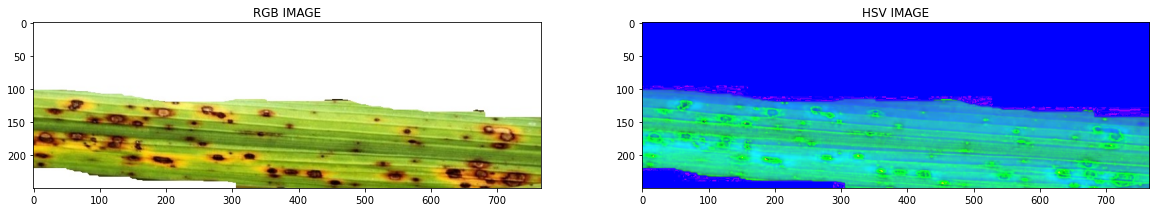

In [5]:
show_img2(20,30, rgb1, hsv1, "RGB IMAGE", "HSV IMAGE")

## SHARPENING

In [6]:
kernel_sharpening = np.array(  [[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]]           
                )

In [7]:
rgb_sharpening = cv2.filter2D(src=rgb1, ddepth=-1, kernel=kernel_sharpening)

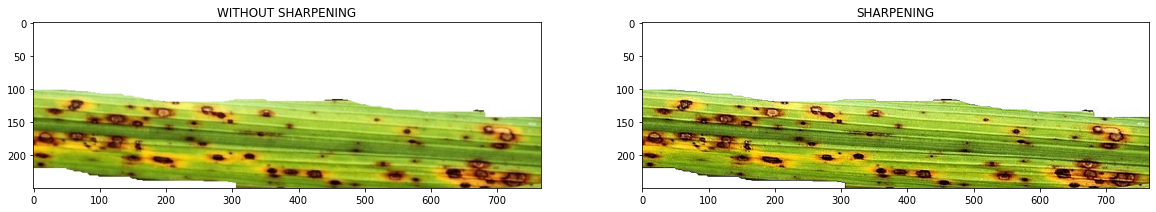

In [8]:
show_img2(20,30,rgb1, rgb_sharpening, "WITHOUT SHARPENING", "SHARPENING")

## BRIGHTNESS & CONTRAST

In [9]:
def brightness_contrast(citra, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(citra, alpha_b, citra, 0, gamma_b)
    else:
        buf = citra.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

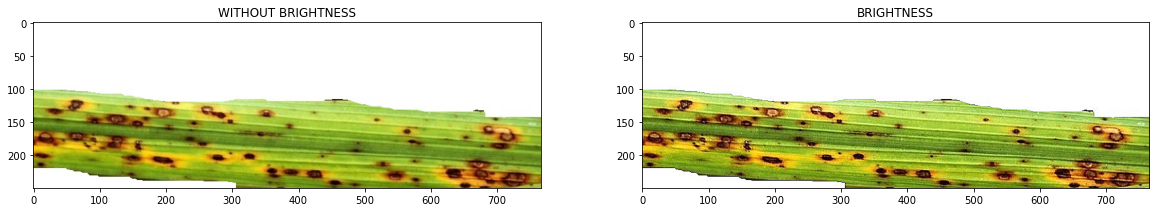

In [10]:
rgb_br = brightness_contrast(rgb_sharpening, brightness=5, contrast=0)
show_img2(20,30,rgb1, rgb_br, "WITHOUT BRIGHTNESS", "BRIGHTNESS")

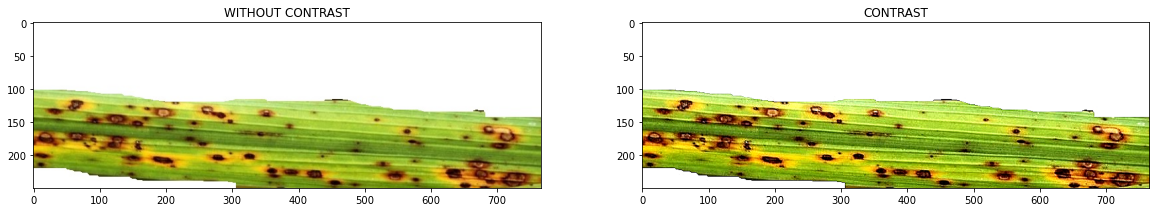

In [11]:
rgb_co = brightness_contrast(rgb_br, brightness=0, contrast=10)
show_img2(20,30,rgb1, rgb_co, "WITHOUT CONTRAST", "CONTRAST")

## GRAFIK WARNA DAN RANGE WARNA

In [12]:
def grafikwarna(img):
    r, g, b = cv2.split(img)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")
    plt.show()

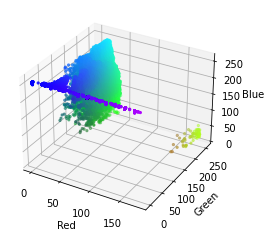

In [13]:
grafikwarna(hsv1)

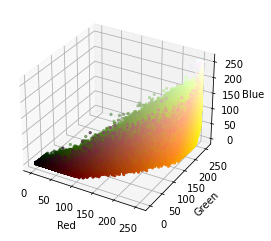

In [14]:
grafikwarna(rgb_co)

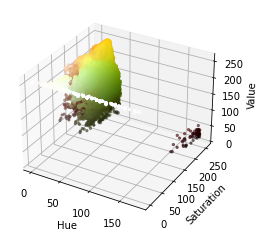

In [15]:
h,s,v=cv2.split(hsv1)
fig=plt.figure()
axis=fig.add_subplot(1,1,1,projection="3d")
pixel_colors = rgb1.reshape((np.shape(rgb1)[0]*np.shape(rgb1)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
axis.scatter(h.flatten(), s.flatten(), v.flatten(),facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")

plt.show()

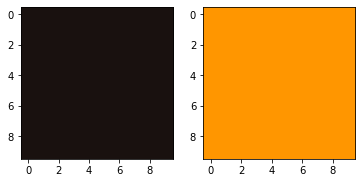

In [16]:
# dark=(10, 75, 150)
# light=(20, 250, 250)

dark=(10, 100, 25)
light=(25, 255, 255)

l_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
d_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(d_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(l_square))
plt.show()

## SEGMENTASI

In [17]:
#hilangin putihnya (ngambil warna kuning aja)
def segment_fish(image, terang, gelap):

    # Convert the image into HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Apply the orange mask 
    mask = cv2.inRange(hsv_image, terang, gelap)

    result = cv2.bitwise_and(image, image, mask=mask)

    # # Clean up the segmentation using a blur
    # blur = cv2.GaussianBlur(result, (7, 7), 0)
    return result

In [18]:
imgFinal = segment_fish(rgb_co, dark, light)

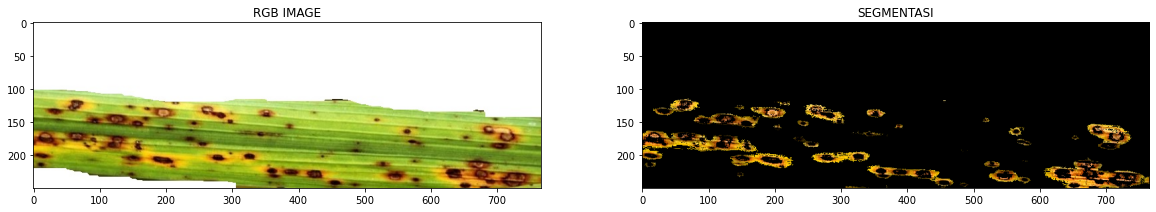

In [19]:
show_img2(20,30,rgb1, imgFinal, "RGB IMAGE", "SEGMENTASI")

## SEGMENTASI KEDUA

In [20]:
#hilangin putihnya (ngambil warna kuning aja)
def colorExtraction(img):
    imgHsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_val = np.array([10,100,25])
    upper_val = np.array([25, 255, 255])
    return cv2.inRange(imgHsv, lower_val, upper_val)

# masking dari gambar aslinya
def getStale(image, rgb):
    stale = colorExtraction(image)
    maskParasite = cv2.bitwise_and(rgb, rgb, mask=stale)
    return maskParasite

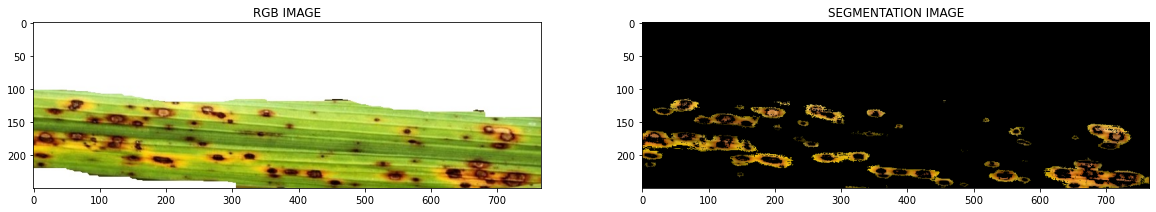

In [21]:
staleOnlyMask = getStale(rgb_co, rgb1)

show_img2(20,30, rgb1, staleOnlyMask, "RGB IMAGE", "SEGMENTATION IMAGE")

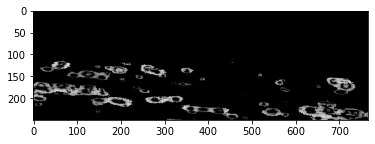

In [22]:
# Gambar yang akan diproses glcmnya
staleOnlyGray = cv2.cvtColor(staleOnlyMask, cv2.COLOR_RGB2GRAY)

plt.imshow(staleOnlyGray, 'gray')

## MORFOLOGI CITRA (OPENING)

In [23]:
ret, thr = cv2.threshold(staleOnlyGray, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


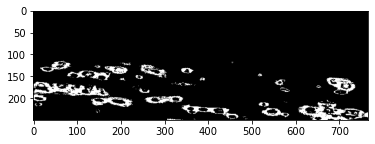

In [24]:
plt.imshow(thr, cmap='gray')

In [25]:
kernelMorfologi = np.ones((5,5), np.uint8)

erosion = cv2.erode(thr, kernelMorfologi, iterations=1)
dilation = cv2.dilate(thr, kernelMorfologi, iterations=1)
opening = cv2.dilate(erosion, kernelMorfologi, iterations=1)
closing = cv2.erode(dilation, kernelMorfologi, iterations=1)

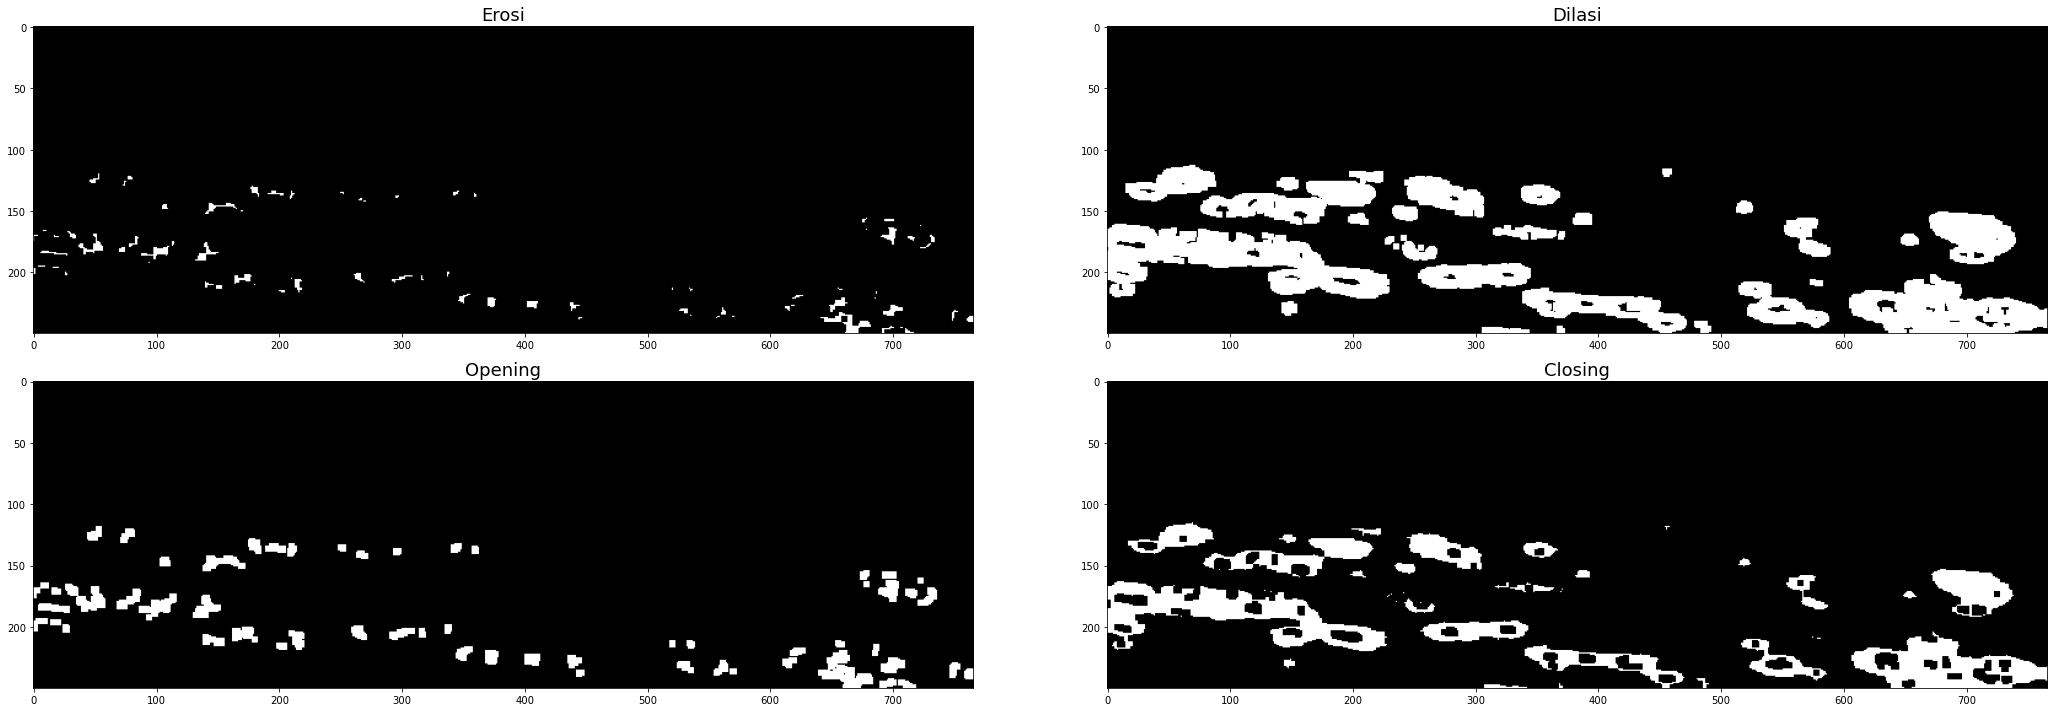

In [26]:
titlesThr = ['Erosi', 'Dilasi', 'Opening', 'Closing']

all_imageThr = [erosion, dilation, opening, closing]
show_manyImg(30,10, all_imageThr, titlesThr, 2, 2)

CATATAN: MORFOLOGI DEFAULTNYA FOREGROUND WARNA PUTIH (OPENCV)

## DRAW CONTOUR

In [27]:
def convertBinary(image):
    ret, binary = cv2.threshold(image,30,255,cv2.THRESH_BINARY)
    return binary

In [28]:
binaryImgResult = convertBinary(opening)

In [29]:
contours, hierarchy = cv2.findContours(binaryImgResult, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_Draw = cv2.drawContours(rgb1, contours, -1, (255,0,0), 1)

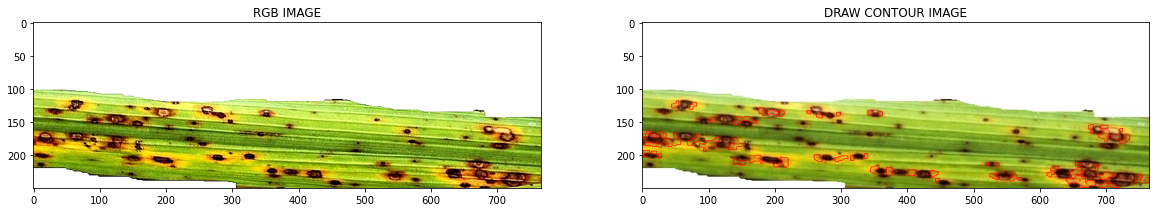

In [30]:
show_img2(20,30, rgb_co, img_Draw, "RGB IMAGE", "DRAW CONTOUR IMAGE")

## SHOW ALL PREPROCESSING

In [31]:
rgbImage = cv2.imread('rice_leaf_diseases/Brown spot/brown-spot-1.jpg')
rgbImage =cv2.cvtColor(rgbImage,cv2.COLOR_BGR2RGB)

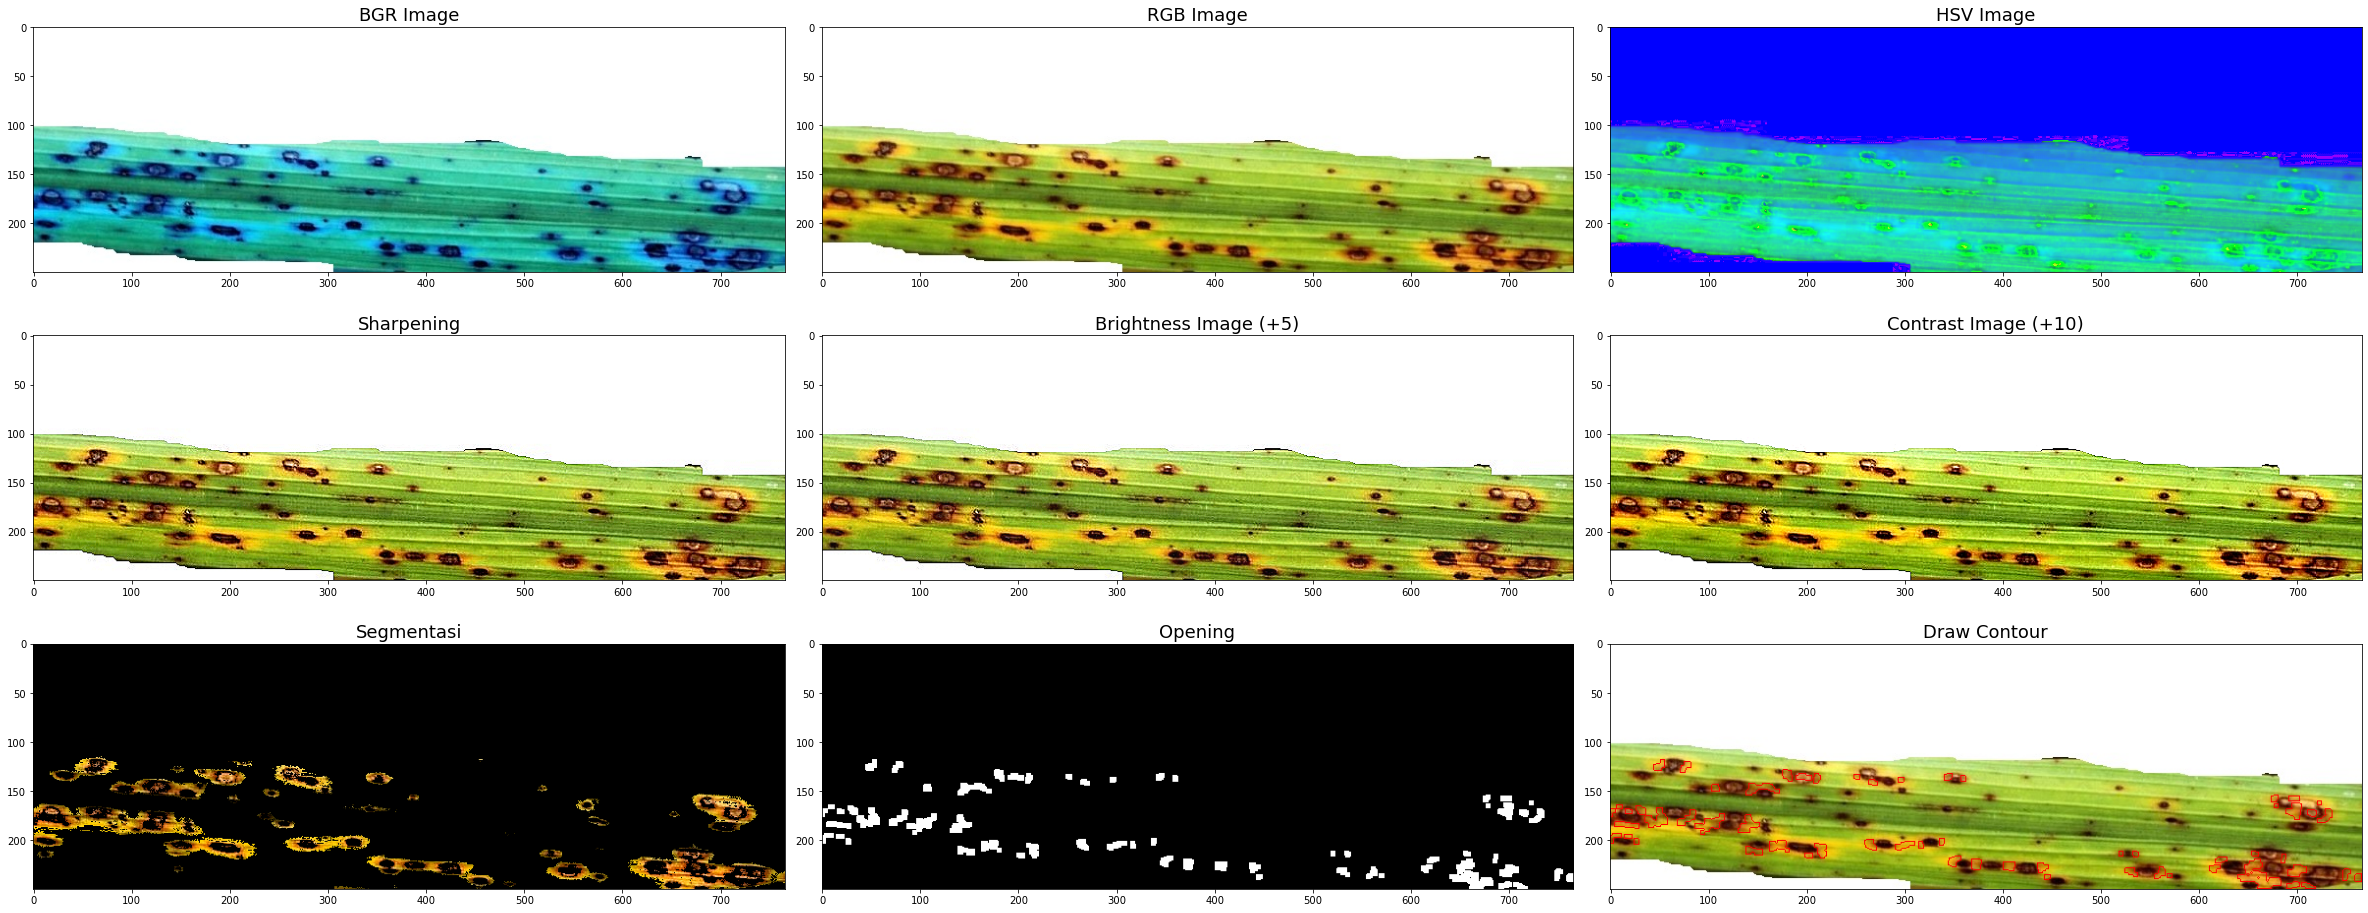

In [32]:
none = np.zeros(img1.shape)
titles = ['BGR Image','RGB Image','HSV Image', 'Sharpening','Brightness Image (+5)', 
        'Contrast Image (+10)', 'Segmentasi', 'Opening', 'Draw Contour']

all_image = [img1,rgbImage,hsv1,rgb_sharpening, rgb_br,rgb_co, imgFinal, opening, img_Draw]

show_manyImg(33,13,all_image, titles, 3, 3)

## IMPORT DATASET

In [33]:
#IMPORT UNTUK GLCM (FOLDER IMAGE_FOR_GLCM)

dataset_dir = "rice_leaf_diseases/" 

data = [] #menyimpan data piksel gambar
labels = [] 
names = []  #menyimpan nama gambar
for sub_folder in tqdm(os.listdir(dataset_dir), desc="load"):
    sub_folder_files = os.listdir(os.path.join(dataset_dir, sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img = cv2.cvtColor(cv2.imread(os.path.join(dataset_dir, sub_folder, filename)), cv2.COLOR_BGR2RGB)
        img_sharpening = cv2.filter2D(src=img, ddepth=-1, kernel=kernel_sharpening)
        img_br_co2 = brightness_contrast(img_sharpening, brightness=0, contrast=10)
        staleOnlyMask = getStale(img_br_co2, img)
        staleOnlyGray = cv2.cvtColor(staleOnlyMask, cv2.COLOR_RGB2GRAY)
        ret, thrBaru = cv2.threshold(staleOnlyGray, 0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        thrBaru = 255-thrBaru
        erosionBaru = cv2.erode(thrBaru, kernelMorfologi, iterations=1)
        openingBaru = cv2.dilate(erosionBaru, kernelMorfologi, iterations=1)
        plt.imsave("image_for_glcm/"+filename, openingBaru)
        data.append(openingBaru)
        labels.append(sub_folder)
        names.append(filename)

data = np.array(data)
labels = np.array(labels)
names = np.array(names)

load: 100%|██████████| 3/3 [00:19<00:00,  6.60s/it]
/tmp/ipykernel_56304/2291845945.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


In [34]:
def derajat0 (img):

    #mencari nilai terbesar atau tertinggi dari piksel image
    max = np.max(img)

    #membuat array kosong yang nantinya digunakan untuk menampung hasil concurence dari image
    imgTmp = np.zeros([max+1,max+1])

    #looping agar dapat mengolah semua piksel pada gambar
    for i in range (len(img)): #looping untuk kolom
        for j in range(len(img[i])-1): #looping untuk baris

            #menentukan matrik concurence
            #dimana derajat0 berarti pengambilan nilai piksel kekanan dari piksel asal
            #misalkan jika piksel[0,0] = 1 dan piksel[0,1]=3(dikanannnya piksel[0,0]), maka
            #concurence[1,3] akan ditambah 1 dan seterusnya
            imgTmp[img[i,j],img[i,j+1]] +=1 
    
    #mentranpos array hasil concurence
    transpos = np.transpose(imgTmp)

    #menjumlahkan array transpos dengan concurence
    data = imgTmp+transpos

    #membuat var yang nantinya digunakan untuk menyimpan hasil penjumlahan 
    tmp = 0
    #normalisasi
    for i in range (len(data)):
        for j in range(len(data)):
            #menambahkan semua piksel pada var data
            tmp+=data[i,j]
                
    for i in range(len(data)):
        for j in range(len(data)):
            #membagi data dengan hasil penambahan tadi
            data[i,j]/=tmp
            
    #mengembalikan var data
    return data

In [35]:
def derajat45 (img):

    #mencari nilai terbesar atau tertinggi dari piksel image
    max = np.max(img)

    #membuat array kosong yang nantinya digunakan untuk menampung hasil concurence dari image
    imgTmp=np.zeros([max+1,max+1])

    #looping agar dapat mengolah semua piksel pada gambar
    for i in range (len (img)-1):
        for j in range (len (img[i])-1):
            imgTmp[img[i+1,j],img[i,j+1]] += 1
    
    #mentranpos array hasil concurence
    transpos= np.transpose(imgTmp)

    #menjumlahkan array transpos dengan concurence
    data= imgTmp+transpos
    
    #membuat var yang nantinya digunakan untuk menyimpan hasil penjumlahan
    tmp=0
    #normalisasi
    for i in range (len(data)):
        for j in range (len(data)):
            #menambahkan semua piksel pada var data
            tmp+=data[i,j]
            
    for i in range (len (data)):
        for j in range (len (data)):
            #membagi data dengan hasil penambahan tadi
            data[i,j]/=tmp
    #mengembalikan var data
    return data

In [36]:
def derajat90 (img):

    #mencari nilai terbesar atau tertinggi dari piksel image
    max = np.max(img)

    #membuat array kosong yang nantinya digunakan untuk menampung hasil concurence dari image
    imgTmp=np.zeros([max+1,max+1])

    #looping agar dapat mengolah semua piksel pada gambar
    for i in range (len (img)-1):
        for j in range (len (img[i])):
            imgTmp[img[i+1,j],img[i,j]] += 1
            
    #mentranpos array hasil concurence
    transpos= np.transpose(imgTmp)

    #menjumlahkan array transpos dengan concurence
    data= imgTmp+transpos
    
    #membuat var yang nantinya digunakan untuk menyimpan hasil penjumlahan
    tmp=0
    #normalisasi
    for i in range (len(data)):
        for j in range (len(data)):
            #menambahkan semua piksel pada var data
            tmp+=data[i,j]
            
    for i in range (len (data)):
        for j in range (len (data)):
            #membagi data dengan hasil penambahan tadi
            data[i,j]/=tmp
    #mengembalikan var data
    return data

In [37]:
def derajat135 (img):

    #mencari nilai terbesar atau tertinggi dari piksel image
    max = np.max(img)

    #membuat array kosong yang nantinya digunakan untuk menampung hasil concurence dari image
    imgTmp=np.zeros([max+1,max+1])
    for i in range (len (img)-1):
        for j in range (len (img[i])-1):
            imgTmp[img[i,j],img[i+1,j+1]] += 1
            
    #mentranpos array hasil concurence
    transpos= np.transpose(imgTmp)

    #menjumlahkan array transpos dengan concurence
    data= imgTmp+transpos
    
    #membuat var yang nantinya digunakan untuk menyimpan hasil penjumlahan
    tmp=0
    #normalisasi
    for i in range (len(data)):
        for j in range (len(data)):
            #menambahkan semua piksel pada var data
            tmp+=data[i,j]
            
    for i in range (len (data)):
        for j in range (len (data)):
            #membagi data dengan hasil penambahan tadi
            data[i,j]/=tmp
    #mengembalikan var data
    return data

In [38]:
def dissimilarity(data): 
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)): 
        for j in range(len(data)):

            #rumus : p(x,y)+|i-j|
            simpan+= data[i,j]+abs(i-j)
    #mengembalikan nilai var simpan
    return simpan

In [39]:
def ASM(data): 
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):

            #rumus : p(x,y)^2
            simpan+= pow(data[i,j],2)
    #mengembalikan nilai var simpan
    return simpan 

In [40]:
def contrast(data):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):

            #rumus : p(x,y)+(i-j)^2
            simpan+= data[i,j]+pow(i-j,2)
    #mengembalikan nilai var simpan
    return simpan

In [41]:
def entropi(data):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range(len(data)):
        for j in range(len(data)):
            if data[i,j] > 0:
                #rumus : -(p(x,y)*log^2(i-j)
                simpan+= -(data[i,j] * math.log2(data[i,j]))
    #mengembalikan nilai var simpan
    return simpan

In [42]:
def energy(data):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            #rumus : sqrt(p(x,y)^2) atau sqrt(ASM)
            simpan+=pow(data[i,j],2)
    #mengembalikan nilai var simpan
    return simpan

In [43]:
def homogenitas(data):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            #rumus : p(x,y)/1+(i-j)^2
            simpan+=data[i,j]/(1+pow((i-j),2))
    #mengembalikan nilai var simpan
    return simpan

In [44]:
def correlation(data,mI,mJ,tI,tJ):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            simpan+=((i-mI)*(j-mJ)*data[i,j])/(tI*tJ)
    #mengembalikan nilai var simpan
    return simpan

In [45]:
def meanI(data):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            simpan+= i * data[i,j]
    #mengembalikan nilai var simpan
    return simpan

In [46]:
def meanJ(data):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            simpan+= j * data[i,j]
    #mengembalikan nilai var simpan
    return simpan

In [47]:
def taoI(data,mI):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            simpan+= pow((i-mI),2)*data[i,j]
    
    #mengakarkan var simpan
    simpan = math.sqrt(simpan)
    #mengembalikan nilai var simpan
    return simpan

In [48]:
def taoJ(data,mJ):
    simpan = 0 #membuat var simpan yang nantinya digunakan untuk menyimpan hasil
    for i in range (len(data)):
        for j in range(len(data)):
            simpan+= pow((j-mJ),2)*data[i,j]
    #mengakarkan var simpan
    simpan = math.sqrt(simpan)
    #mengembalikan nilai var simpan
    return simpan

In [49]:
data[1].shape

(514, 768)

## RESIZE

In [50]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):

    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

In [51]:
resize = []
for i in tqdm(range(len(data)), desc='load'):
    resize.append(image_resize(data[i],width=900)) 

load: 100%|██████████| 120/120 [00:01<00:00, 118.50it/s]


In [52]:
hasil = []
for i in tqdm(range(len(resize)), desc='load'):
    dat = []
    dat.append(derajat0 (resize[i]))      #mencari piksel derajat0
    dat.append(derajat45 (resize[i]))     #mencari piksel derajat45
    dat.append(derajat90 (resize[i]))     #mencari piksel derajat90
    dat.append(derajat135 (resize[i]))    #mencari piksel derajat135
    hasil.append(dat)

load:  18%|█▊        | 21/120 [00:47<03:45,  2.28s/it]


KeyboardInterrupt: 

In [ ]:
frame = []
indeks = 0 #digunakan untuk menentukan indeks dari nama filenya
for i in tqdm(hasil, desc='load'):
    save = []
    #untuk menginputkan nama dari file
    save.append(names[indeks])
    indeks+=1
    for j in i:

        #memanggil fungsi energy
        en = energy(j)
        #menginputkan kedalam var save
        save.append(en)
        
        #memanggil fungsi homogenitas
        hm = homogenitas(j)
        #menginputkan kedalam var save
        save.append(hm)
        
        #memanggil fungsi entropi
        ent = entropi(j)
        #menginputkan kedalam var save
        save.append(ent)
        
        #memanggil fungsi contrast
        con = contrast(j)
        #menginputkan kedalam var save
        save.append(con)

        #memanggil fungsi dissimilarity
        dis = dissimilarity(j)
        #menginputkan kedalam var save
        save.append(dis)

        #memanggil fungsi ASM
        asm = ASM(j)
        #menginputkan kedalam var save
        save.append(asm)
        
        mI = meanI(j)
        mJ = meanJ(j)
        tI = taoI(j,mI)
        tJ = taoJ(j,mJ)
        
        #memanggil fungsi correlation
        cor = correlation(j,mI,mJ,tI,tJ)
        #menginputkan kedalam var save
        save.append(cor)
        
    #menginputkan isi var save ke var frame
    frame.append(save)

load: 100%|██████████| 120/120 [06:53<00:00,  3.45s/it]


In [ ]:
#membuat var yang nantinya digunakan sebagai header
headerPass = ['path','energi0','homogenitas0','entropy0','contras0','dissimilarity0','ASM0','correlation0'
            ,'energi45','homogenitas45','entropy45','contras45','dissimilarity45','ASM45','correlation45'
            ,'energi90','homogenitas90','entropy90','contras90','dissimilarity90','ASM90','correlation90'
            ,'energi135','homogenitas135','entropy135','contras135','dissimilarity135','ASM135','correlation135']
#menginputkan var frame sebagai isi dari tabel
df = pd.DataFrame(frame, columns=headerPass)

In [ ]:
#digunakan untuk mensave data menjadi file csv dengan nama Jurnalmodul8
df['labels'] = labels
df.to_csv(r'image_for_glcm/finalresult_ekstraksiciri.csv', index=False)

In [ ]:
df

,path,energi0,homogenitas0,entropy0,contras0,dissimilarity0,ASM0,correlation0,energi45,homogenitas45,...,ASM90,correlation90,energi135,homogenitas135,entropy135,contras135,dissimilarity135,ASM135,correlation135,labels
0,brown-spot-25.JPG,0.954253,0.989211,0.306337,7.158170e+08,5592321.0,0.954253,0.968685,0.949474,0.985165,...,0.950560,0.923517,0.949349,0.985057,0.344857,7.158170e+08,5592321.0,0.949349,0.909977,Brown spot
1,brown-spot-12.jpg,0.742376,0.978777,1.067667,7.158170e+08,5592321.0,0.742376,0.979366,0.728567,0.953264,...,0.732660,0.948599,0.727917,0.952576,1.246058,7.158170e+08,5592321.0,0.727917,0.932773,Brown spot
2,brown-spot-20.JPG,0.932750,0.979182,0.522675,7.158170e+08,5592321.0,0.932750,0.943299,0.923675,0.968940,...,0.925114,0.789914,0.924044,0.969154,0.601114,7.158170e+08,5592321.0,0.924044,0.769213,Brown spot
3,brown-spot-1.jpg,0.808033,0.978192,0.919068,7.158170e+08,5592321.0,0.808033,0.969490,0.795524,0.956007,...,0.800455,0.936894,0.796885,0.957426,1.055307,7.158170e+08,5592321.0,0.796885,0.919643,Brown spot
4,brown-spot-10.jpg,0.814720,0.988140,0.711443,7.158170e+08,5592321.0,0.814720,0.980361,0.806812,0.974399,...,0.811394,0.966778,0.806831,0.974407,0.810008,7.158170e+08,5592321.0,0.806831,0.950032,Brown spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,bacterial-leaf-blight-2.jpg,0.910776,0.984367,0.519349,7.158170e+08,5592321.0,0.910776,0.982870,0.901521,0.974594,...,0.902350,0.915966,0.900902,0.974212,0.608093,7.158170e+08,5592321.0,0.900902,0.906036,Bacterial leaf blight
116,bacterial-leaf-blight-28.JPG,0.877561,0.974238,0.758601,7.158170e+08,5592321.0,0.877561,0.978681,0.862880,0.956862,...,0.864471,0.876866,0.863395,0.957428,0.889369,7.158170e+08,5592321.0,0.863395,0.872961,Bacterial leaf blight
117,bacterial-leaf-blight-19.JPG,0.943423,0.991244,0.325372,7.158170e+08,5592321.0,0.943423,0.988852,0.938174,0.985361,...,0.938787,0.919659,0.938274,0.985443,0.379338,7.158170e+08,5592321.0,0.938274,0.918220,Bacterial leaf blight
118,bacterial-leaf-blight-21.JPG,0.910115,0.981861,0.546576,7.158170e+08,5592321.0,0.910115,0.987165,0.900313,0.970741,...,0.901180,0.892172,0.899236,0.969760,0.649143,7.158170e+08,5592321.0,0.899236,0.880899,Bacterial leaf blight
